# Fractal in Biology

This notebook checks the result in [West, et al. (1997)](https://www.science.org/doi/10.1126/science.276.5309.122). This paper concludes that fractal in biology results in the minimization of total energy cost. In the specific case considered by the authors, the mammalian circulatory systems, the fractal branching of capillary vessel naturally arises from reducing the energy cost of vessel circulation. Here, we check this result by numerical optimization method. Our discussion is based on a new paper by [Etienne, et al. (2006)](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2435.2006.01136.x), which has better writing style and notations. 

## Notations

We follow the notations in Etinene, et al. (2006):

- $C$: number of branching levels.
- $k$: branching level, from $1$ to $C$.
- $n_k$: number of branches at $k$ level.
- $r_k$: radius of vessel at $k$ level.
- $l_k$: length of vessel at $k$ level.
- $\nu_k$: $n_{k+1} / n_k$.
- $\rho_k$: $r_{k+1} / r_k$.
- $\lambda_k$: $l_{k+1} / l_k$.

## Assumptions

The assumption that the properties of capillary are universal for all mammals implies that the $n_C$, $l_C$, and $r_C$ are fixed. So, we have

$$ l_k = \frac{l_k}{l_{k+1}} \cdots \frac{l_{C-1}}{l_C} l_C = l_C \lambda_k^{-1} \cdots \lambda_{C-1}^{-1} = l_C \prod_{i=k}^{C-1} \lambda_i^{-1}. $$

The same,

$$ r_k = r_C \prod_{i=k}^{C-1} \rho_i^{-1}, $$

  and

$$ n_k = n_C \prod_{i=k}^{C-1} \nu_i^{-1}. $$

Based on assumption of area-preserving, we have that $n_k r_k^2$ is independent of $k$. This implies

$$ \rho_k = \nu_k^{-1/2}. $$

And by assumption of space-fulfilling, we have that $n_k l_k^3$ is independent of $k$. This implies

$$ \lambda_k = \nu_k^{-1/3}. $$

Because of these, the unique degree of freedom is the $\nu$.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tqdm import tqdm
import matplotlib.pyplot as plt

2024-02-26 10:03:10.930398: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We use several samples in searching optimal parallelly. So, the $\nu$, or for numerical stability $\ln \nu$, has tensor shape `[samples, levels]`.

In [2]:
SAMPLES = 8
LEVELS = 64
RANDOM_SEED = 42

In [3]:
def init_variable(shape, strategy, range_):
    return tf.Variable(initialize(shape, strategy, range_))

def initialize(shape, strategy, range_):
    if strategy == 'zero':
        return tf.zeros(shape)
    elif strategy == 'uniform':
        return tf.random.uniform(
            shape, minval=-range_, maxval=range_, seed=RANDOM_SEED)
    else:
        raise ValueError()

log_nu = initialize([SAMPLES, LEVELS], 'uniform', 1e-1)

## Loss Function

The quantity to be minimized is the total resistance of the vessel system. By [Hagen-Poiseuille equation](https://en.wikipedia.org/wiki/Hagen%E2%80%93Poiseuille_equation#Equation), we have the difference of pressure at level $k$, $\Delta p_k = Q_k R_k$ where $Q_k$ represents the flow rate and $R_k := (8 \mu l_k)/(\pi r_k^4)$. Analogy to electricity, $\Delta p_k$ corresponds to difference of potential $\Delta V$, and $Q_k$ to current $I$. So, the $R_k$ is the resistance. At level $k$, the vessels are parallel. And for different levels, vessels are serial. So, the total resistance comes to be

$$ R_b = \sum_{k=1}^{C} \frac{R_k}{n_k} = \frac{8\mu}{\pi} \sum_{k=1}^{C} \frac{l_k}{r_k^4 n_k} = \frac{8\mu}{\pi} \frac{l_C}{r_C^4 n_C} \sum_{k=1}^{C} \prod_{i=k}^{C-1} \frac{\rho_i^4 \nu_i}{\lambda_i}. $$

Plugging into the relation between $\rho$, $\lambda$ and $\nu$, we find

$$ R_b = \frac{8\mu}{\pi} \frac{l_C}{r_C^4 n_C} \sum_{k=1}^{C} \prod_{i=k}^{C-1} \nu_i^{-2/3}. $$

In [4]:
def get_resistance(log_nu):
    """Up to factors and a constant."""
    logits = []
    for i in range(LEVELS):
        logits.append(-(2/3) * tf.reduce_sum(log_nu[:, i:], axis=1))
    logits = tf.stack(logits, axis=1)
    return tf.exp(tf.reduce_logsumexp(logits, axis=1))

get_resistance(log_nu)

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([58.46727 , 66.05416 , 64.88039 , 82.40974 , 57.53744 , 74.122025,
       88.93285 , 52.87246 ], dtype=float32)>

It is also assumed that the blood volume is proportional to the body size. The blood volumne is given by

$$ V_b = \pi \sum_{k=1}^C r_k^2 l_k n_k = \pi r_C^2 l_C n_C \sum_{k=1}^C \prod_{i=k}^{C-1} \frac{1}{\rho_i^2 \lambda_i \nu_i} = \pi r_C^2 l_C n_C \sum_{k=1}^C \prod_{i=k}^{C-1} \nu_i^{1/3}. $$

If the body size is fixed, then $V_b$ shall be fixed too.

In [5]:
def get_volume(log_nu):
    """Up to factors and a constant."""
    logits = []
    for i in range(LEVELS):
        logits.append((1/3) * tf.reduce_sum(log_nu[:, i:], axis=1))
    logits = tf.stack(logits, axis=1)
    return tf.exp(tf.reduce_logsumexp(logits, axis=1))

get_volume(log_nu)

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([67.09487 , 63.092766, 63.75061 , 56.918922, 67.57807 , 59.56954 ,
       54.550034, 71.051865], dtype=float32)>

Altogether, the loss function shall be

$$ R_b(\nu) + \mu_b \left( \frac{V_b(\nu)}{\bar{V}_b} - 1 \right), $$

for some observed values $\bar{V}_b$ and $\bar{N}$ given. By obsorbing the constant factors, it becomes

$$ \sum_{k=1}^{C} \prod_{i=k}^{C-1} \nu_i^{-2/3} + \mu_b \left( \frac{ \sum_{k=1}^C \prod_{i=k}^{C-1} \nu_i^{1/3} }{ \bar{V}_b } - 1 \right). $$

What is a proper value of $\bar{V}_b$. It is natural to suppose that $n_{k+1}/n_k >= 2$. This means $\bar{V}_b$ shall be greater than the volume given by $\nu = 2$. And it shall not be too large, for numerical consideration.

In fact, it is sufficient for the optimized volume to approximate the order of $\bar{V}_b$. We can regard this optimized volume as the real $\bar{V}_b$. In other words, $\bar{V}_b$ is used to determine the order, but not the accurate value.

In [6]:
least_volume = get_volume(np.log(2 * np.ones([1, LEVELS])))
np.log10(least_volume)

array([7.10747496])

In [7]:
TRUE_VB = 1e+10

In [8]:
def get_loss(log_nu, mu_b, mu_n, l2):
    """l2 for L2-regulation."""
    main = get_resistance(log_nu)
    constraints = []
    loss = main
    for mu, c in [
        (mu_b, get_volume(log_nu) / TRUE_VB - 1),
        # other constraints...
    ]:
        loss = mu * c + l2 * tf.square(c)
        constraints.append(c)
    return loss, main, constraints

get_loss(log_nu, 0.2, 0.1, 0.)

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([58.46727 , 66.05416 , 64.88039 , 82.40974 , 57.53744 , 74.122025,
        88.93285 , 52.87246 ], dtype=float32)>,
 [<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-1., -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>])

## Gradient Descent with Constraints

The gradient descent algorithm with constraints is described in [Platt and Barr (1988)](https://papers.nips.cc/paper_files/paper/1987/file/a87ff679a2f3e71d9181a67b7542122c-Paper.pdf). Briefly, descent on the parameters (the $\ln \nu$ here) and ascent on the multipliers (the $\mu_b$ here). For numerical stability, it is suggested to add an $L_2$-regulation.

In [9]:
def get_train_step(optimizer, l2):
    step = tf.Variable(0, dtype=tf.int32, trainable=False)
    l2 = tf.convert_to_tensor(l2)

    @tf.function
    def train_step(log_nu, mu_b, mu_n):
        with tf.GradientTape() as tape:
            loss, main, constraints = get_loss(log_nu, mu_b, mu_n, l2)
            total_loss = tf.reduce_sum(loss)

        vars = [log_nu, mu_b, mu_n]
        grads = tape.gradient(total_loss, vars,
                              unconnected_gradients='zero')
        # Descent for parameters and ascent for multipliers:
        grads_and_vars = []
        for i, var in enumerate(vars):
            if i < 1:
                grads_and_vars.append((grads[i], vars[i]))
            else:
                grads_and_vars.append((-grads[i], vars[i]))

        optimizer.apply_gradients(grads_and_vars)
        check_nan(vars)
        step.assign_add(1)
        return main, constraints, grads_and_vars

    return train_step, step
    

def check_nan(xs):
    for x in xs:
        try:
            tf.debugging.check_numerics(x, message='')
        except Exception as e:
            raise ValueError('NaN value.')

In [10]:
log_nu = init_variable([SAMPLES, LEVELS], 'uniform', 1e-1)
mu_b = init_variable([SAMPLES, 1], 'uniform', 1e-1)
mu_n = init_variable([SAMPLES, 1], 'uniform', 1e-1)
optimizer = keras.optimizers.adam_v2.Adam()
train_step, step = get_train_step(optimizer, 1e-1)

In [11]:
main, constraints, _ = train_step(log_nu, mu_b, mu_n)
main, constraints

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([72.2097  , 52.636707, 59.481182, 57.71217 , 65.1034  , 74.897575,
        58.250607, 60.027817], dtype=float32)>,
 [<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-1., -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>])

In [12]:
for i in tqdm(range(100000)):
    train_step(log_nu, mu_b, mu_n)

100%|███████████████████████████████████████████████████████████████████████████| 100000/100000 [01:30<00:00, 1102.06it/s]


Let us check the optimization results:

In [13]:
_, main, constraints = get_loss(log_nu, mu_b, mu_n, 0.)
main

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.9309087 , 0.8466217 , 0.8412973 , 0.84637946, 0.843056  ,
       0.93205494, 0.91598314, 0.9057081 ], dtype=float32)>

In [14]:
constraints

[<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([-1.0180473e-04,  2.9683113e-04, -9.0301037e-05,  2.2625923e-04,
         3.0827522e-04, -7.7009201e-05,  6.9141388e-06,  8.6379051e-04],
       dtype=float32)>]

In [18]:
min_i = tf.argmin(main)
min_i, main[min_i], [c[min_i] for c in constraints]

(<tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8412973>,
 [<tf.Tensor: shape=(), dtype=float32, numpy=-9.030104e-05>])

And for the appearance of fractal:

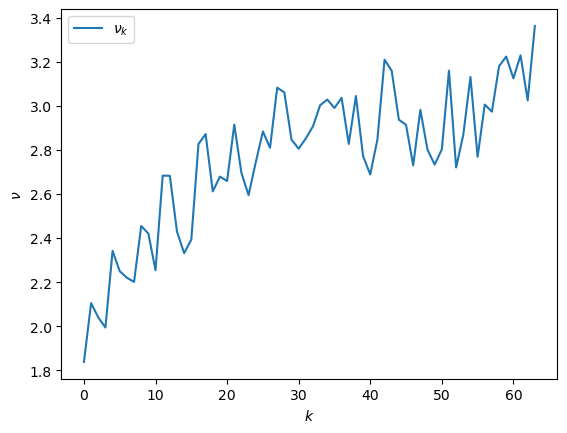

In [23]:
plt.plot(tf.exp(log_nu[min_i, :]), label='$\\nu_k$')
plt.xlabel('$k$')
plt.ylabel('$\\nu$')
plt.legend()
plt.show()

In this figure, even though fluctuated, the $\nu_k$ begins to saturated for greater $k$. It means fractal starts to appear in the higher levels.

Now, we can see how many branches there are. Notice that

$$ \frac{n_c}{n_1} = \frac{n_C}{n_{C-1}} \cdots \frac{n_2}{n_1} = \prod_{k=1}^{C-1} \nu_k, $$

and that $n_1 = 1$, we find

$$ n_c = \prod_{k=1}^{C-1} \nu_k. $$

In [17]:
def get_nc(log_nu):
    return tf.exp(tf.reduce_sum(log_nu, axis=1))

np.log2(get_nc(log_nu))

array([92.92571 , 93.3303  , 93.07226 , 93.1247  , 93.08912 , 93.283775,
       93.004295, 92.92584 ], dtype=float32)

## Conclusion

* From the trained `log_nu`, it is indicated that fractal appears in the higher levels.
* Assigning a proper $\bar{V}_b$ is critical for obtaining plausible result.

## Discussion

The resistance $R_b(\nu)$ can be seen as an action. The true value of $\nu$ locates in its minima. So, we can construct a probabilistic model of $\nu$, the branching of vessel system, as

$$ p(\nu) \propto \exp(-\beta R_b(\nu)) \delta(V_b(\nu) - \bar{V}_b), $$

for any positive $\beta$ characterizing the randomness.

TODO